In [1]:
import numpy as np
import numba
import quantecon as qe
import matplotlib.pyplot as plt
import datetime
import interpolation

In [2]:
beta=0.96
alpha=0.36
delta=0.08
a_max = 40.
b=3.

In [21]:
#rho=0.4
rho=0.6

#mu=0
mu=3.
#mu=5

#sigma=0.4
sigma=0.4

In [22]:
x = qe.markov.approximation.tauchen(rho,sigma*(1-rho**2)**0.5, m = 3,n = 7)
l_grid = np.exp(x.state_values)
l_dis = x.stationary_distributions
L = np.sum(l_grid * l_dis)
l_min=l_grid[0]
piel = x.P

In [5]:
@numba.guvectorize(['f8[:,:],f8[:,:],f8,f8,f8,f8[:,:],f8[:,:],f8[:,:]'], 
            '(m,l),(l,n),(),(),(),(m,n),(m,n)->(m,n)', nopython=True)
def plc_inner(a_grid, l_grid, phi, r, w, a_temp, cons, drn):
    for i in range(7):
        location = np.where(a_grid<=a_temp[0,i])
        if location[0].shape[0]==0:
            sup = 0
        else:
            sup = np.max(location[0])+1
        drn[sup:601,i] = interpolation.interp(a_temp[:,i], cons[:,i], a_grid[sup:601,0])
        drn[0:sup,i] = (1+r)*a_grid[0:sup,0] + w*l_grid[0,i] + phi

In [6]:
@numba.njit
def plc_c_a(beta, r, w, mu, trans, a_grid, l_grid, drn):
    cons = (beta*(1+r) * ((drn)**(-mu)) @ trans) ** (-1/mu)
    a_temp = (cons + a_grid - w*l_grid)/(1+r) 
    return cons, a_temp

In [7]:
def plc_iter(phi, beta, mu, trans, r, w, a_grid, l_grid):
    
    cons = np.empty((601,7), dtype=np.float64)
    a_temp = np.empty((601,7), dtype=np.float64)
    drn = np.ones((601,7), dtype=np.float64)*12.
    
    n=0
    err=1.    
    
    while err > 1e-5 and n <= 1000:
        dr0=drn.copy()
        cons, a_temp = plc_c_a(beta, r, w, mu, trans, a_grid, l_grid, drn)
        drn = plc_inner(a_grid, l_grid, phi, r, w, a_temp, cons, drn)
    
        if n % 5 == 0:
            err = np.max(np.abs(drn-dr0))
        n+=1
    
    fin = (1+r)*a_grid + w*l_grid - drn
    return fin

In [8]:
@numba.guvectorize(['f8[:,:],f8[:,:],f8[:,:],f8[:,:],f8[:,:]'],
                  '(j,k),(m,n),(m,n),(n,n)->(j,k)', nopython=True)
def demo_temp(temp0, plc, demo, pie, temp):
    for i in range(601):
        for j in range(7):
            temp[i*7+j,0]=plc[i,j]
            temp[i*7+j,1:8]=demo[i,j] * pie[j,:]

In [9]:
@numba.guvectorize(['f8[:,:],f8[:,:], f8[:], f8[:], f8[:,:]'],
                  '(n,n),(j,k),(m),(l)->(m,n)', nopython=True)
def demo_inner(pie, temp, a_grid, itv, demon):
    for k in range(600):
        location = np.where(np.logical_and(np.greater_equal(temp[:,0],a_grid[k]), np.less_equal(temp[:,0],a_grid[k+1])))
        l=location[0]
        demon[k,:] = np.sum(temp[l,1:8]*(np.reshape((temp[l,0]-a_grid[k]), (-1,1))/itv[k]), axis=0) + demon[k,:]
        demon[k+1,:] = np.sum(temp[l,1:8]*(np.reshape((a_grid[k+1]-temp[l,0]), (-1,1))/itv[k]), axis=0) + demon[k+1,:]

In [10]:
def demo_iter(a_grid, plc, pie):
    err = 1.
    n = 0
    
    demon = np.ones((601,7), dtype=np.float64) / (601*7)
    itv = a_grid[1:601]-a_grid[0:600]
    temp0 = np.empty((601*7,8), dtype=np.float64)
    temp=temp0.copy()
    
    while err > 1e-6 and n <= 1000:
        demo = demon.copy()
        demon = np.zeros((601,7), dtype=np.float64)
        temp = demo_temp(temp0, plc, demo, pie, temp)
        demon = demo_inner(pie, temp, a_grid, itv, demon)
        
        if n % 10 == 0:        
            err = np.max(np.abs(demon - demo))
            
        n += 1
        
    return demon

In [11]:
l_grid_re = np.reshape(l_grid, (1,-1))
trans = np.transpose(piel)

ps3=np.empty((20,3), dtype=np.float64)
ps3[:,0]=np.linspace(-0.04, (1-beta)/beta, 20)

for i in range(20):
    r=ps3[i,0]
    k = (((r+delta)/(alpha * L**(1-alpha)))) ** (1/(alpha-1))
    ps3[i,1]=k
    w = (1-alpha) * (k**alpha) * (L**(-alpha))
    
    if r > 0:
        phi = min(b, w*l_min/r)
    else:
        phi = b
    
    a_grid = (np.linspace(0, 1, 601, dtype=np.float64)**2)*(phi+a_max)-phi
    a_grid_re = np.reshape(a_grid, (-1,1))
    plc = plc_iter(phi, beta, mu, trans, r, w, a_grid_re, l_grid_re)
    plc = np.clip(plc ,-phi, a_max)
    
    demo = demo_iter(a_grid, plc, piel)
    ps3[i,2] = np.sum(demo*plc)

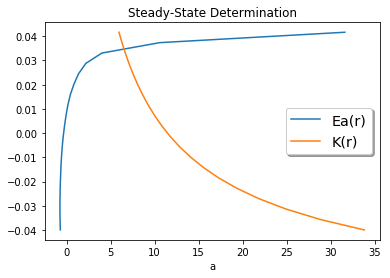

In [18]:
fig, ax = plt.subplots()
ax.plot(ps3[:,2], ps3[:,0], label='Ea(r)')
ax.plot(ps3[:,1], ps3[:,0], label='K(r)')
ax.set_title("Steady-State Determination")
ax.set_xlabel('a')

legend = ax.legend(loc='right', shadow=True, fontsize='x-large')

legend.get_frame()
fig.savefig('A2_graphs/ss_dtm_pl.png', dpi=500)

In [23]:
err = 1.
count = 0
r = 0.01

l_grid_re = np.reshape(l_grid, (1,-1))
trans = np.transpose(piel)

#momentum = 0.15
#lr = 0.001
#decay = 0.98
r_low=-0.04
r_up=(1-beta)/beta

start = datetime.datetime.now()

while err >= 15e-4 and count <= 16:
    k = (((r+delta)/(alpha * L**(1-alpha)))) ** (1/(alpha-1))
    w = (1-alpha) * (k**alpha) * (L**(-alpha))
    
    if r > 0:
        phi = min(b, w*l_min/r)
    else:
        phi = b
    
    a_grid = (np.linspace(0, 1, 601, dtype=np.float64)**2)*(phi+a_max)-phi
    a_grid_re = np.reshape(a_grid, (-1,1))
    plc = plc_iter(phi, beta, mu, trans, r, w, a_grid_re, l_grid_re)
    plc = np.clip(plc ,-phi, a_max)
    
    demo = demo_iter(a_grid, plc, piel)
    kprime = np.sum(demo*plc)
    
    err = np.abs(k - kprime)
    if kprime < k:
        r_low = r
    else:
        r_up = r
    r = 0.5*(r_up+r_low)
    
    if count % 5 ==0:
        print(count)
    
    count += 1

end = datetime.datetime.now()
print(end-start)

0
5
0:00:21.421725


In [16]:
k, kprime, r, w

(6.390075882618307, 6.388724934722765, 0.03617273966471357, 1.2091523735138896)

In [24]:
k, kprime, r, w

(6.6814216025224376, 6.682448314950925, 0.03303873697916669, 1.227701973609213)

(601, 7)